In [3]:
from __future__ import absolute_import, division, print_function, \
    unicode_literals

import os
import math
import pprint
import datetime
import numpy as np
from timeit import default_timer
from collections import defaultdict
from surprise import SVD, SVDpp, KNNBasic, KNNBaseline, \
    GridSearch, Dataset, accuracy, dump


class Recommender:
    def __init__(self, algorithm, param_grid, bsl_options, sim_options,
                 rating_scale=(1, 5), perf_measure='rmse', n_folds=3,
                 dump_model=True, trainset_size=0.8):
        self.algorithm = algorithm
        self.param_grid = param_grid
        self.bsl_options = bsl_options
        self.sim_options = sim_options
        self.rating_scale = rating_scale
        self.perf_measure = perf_measure
        self.n_folds = n_folds
        self.dump_model = dump_model
        self.trainset_size = trainset_size
        self.data = self.load_data()

    def recommend(self, uids, n_items=10, verbose=False):
        data = self.data
        trained_model = os.path.expanduser('./svd')

        try:
            _, algo = dump.load(trained_model)
        except FileNotFoundError:
            # Perform random sampling on the raw ratings
            raw_ratings = data.raw_ratings
            np.random.shuffle(raw_ratings)
            threshold = int(self.trainset_size * len(raw_ratings))
            trainset_raw_ratings = raw_ratings[:threshold]
            test_raw_ratings = raw_ratings[threshold:]

            # Assign new ratings to the original data
            data.raw_ratings = trainset_raw_ratings

            # Perform Grid Search
            if self.perf_measure not in ['rmse', 'fcp']:
                raise ValueError('■ Invalid accuracy measurement provided')

            if verbose:
                print('■ Performing Grid Search')

            data.split(n_folds=self.n_folds)
            grid_search = GridSearch(self.algorithm, param_grid=self.param_grid,
                                     measures=[self.perf_measure], verbose=verbose)
            grid_search.evaluate(data)
            algo = grid_search.best_estimator[self.perf_measure]
            algo.sim_options = self.sim_options
            algo.bsl_options = self.bsl_options
            algo.verbose = verbose

            if verbose:
                print('■ Grid Search completed')
                pp = pprint.PrettyPrinter()
                pp.pprint(vars(algo))

            # Retrain on the whole train set
            if verbose:
                print('■ Training using trainset')
            trainset = data.build_full_trainset()
            algo.train(trainset)
            algo.verbose = verbose
            if self.dump_model:
                dump.dump(trained_model, algo=algo)

            if verbose:
                # Test on the testset
                print('■ Evaluating using testset')
                testset = data.construct_testset(test_raw_ratings)
                predictions = algo.test(testset)
                accuracy.rmse(predictions)

        # Generate top-N recommendations
        print('■ Using the best estimator on full dataset')
        start = default_timer()
        data = self.data
        trainset = data.build_full_trainset()
        testset = trainset.build_anti_testset()
        predictions = algo.test(testset)
        accuracy.mae(predictions)
        accuracy.rmse(predictions)

        duration = default_timer() - start
        duration = datetime.timedelta(seconds=math.ceil(duration))
        print('■ Time elapsed:', duration)

        return self.get_top_predictions(uids, predictions, n_items)

    def get_top_predictions(self, uids, predictions, n_items):
        if not uids:
            raise ValueError('■ Invalid users provided')
        try:
            predictions = self.get_top_n(predictions, n_items)
            return {str(uid): predictions[str(uid)] for uid in list(uids)}
        except KeyError:
            print('■ Cannot find the given user')

    @staticmethod
    def load_data():
        data = Dataset.load_builtin('ml-100k')
        return data

    @staticmethod
    def get_top_n(predictions, n):
        top_n = defaultdict(list)
        for uid, iid, _, est, _ in predictions:
            top_n[uid].append((iid, est))

        for uid, ratings in top_n.items():
            ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = ratings[:n]

        return top_n

In [5]:
uids = [1, 2]
pp = pprint.PrettyPrinter()

In [6]:
# Neighborhood-based collaborative filtering (kNN-basic)
param_grid = {'k': [20, 40, 60]}
sim_options = {'name': 'pearson_baseline', 'user_based': True}
recommender = Recommender(algorithm=KNNBasic,
                          param_grid=param_grid,
                          bsl_options={},
                          sim_options=sim_options,
                          perf_measure='rmse',
                          dump_model=False)

recommendations = recommender.recommend(uids=uids, verbose=True)
pp.pprint(recommendations)

■ Performing Grid Search
------------
Parameters combination 1 of 3
params:  {'k': 20}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 0.9999
------------
------------
Parameters combination 2 of 3
params:  {'k': 40}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0005
------------
------------
Parameters combination 3 of 3
params:  {'k': 60}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 1.0042
------------


In [7]:
# Neighborhood-based collaborative filtering (kNN-baseline)
param_grid = {'k': [20, 40, 60]}
bsl_options = {'method': 'sgd', 'learning_rate': 0.0007}
sim_options = {'name': 'pearson_baseline', 'user_based': True}
recommender = Recommender(algorithm=KNNBaseline,
                          param_grid=param_grid,
                          bsl_options=bsl_options,
                          sim_options=sim_options,
                          perf_measure='rmse',
                          dump_model=False)

recommendations = recommender.recommend(uids=uids, verbose=True)
pp.pprint(recommendations)

■ Performing Grid Search
------------
Parameters combination 1 of 3
params:  {'k': 20}
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 0.9484
------------
------------
Parameters combination 2 of 3
params:  {'k': 40}
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 0.9430
------------
------------
Parameters combination 3 of 3
params:  {'k': 60}
Estimating biases using als...
Computing the msd similarity matrix...
Done co

In [8]:
# Matrix factorization - SVD using Stochastic Gradient Descent
bsl_options = {'method': 'sgd'}
param_grid = {'n_factors': [20, 50], 'lr_all': [0.0003, 0.0007]}
recommender = Recommender(algorithm=SVD,
                          param_grid=param_grid,
                          bsl_options=bsl_options,
                          sim_options={},
                          perf_measure='rmse',
                          dump_model=False,
                          trainset_size=0.8)

recommendations = recommender.recommend(uids=uids, verbose=True)
pp.pprint(recommendations)

■ Performing Grid Search
------------
Parameters combination 1 of 4
params:  {'n_factors': 20, 'lr_all': 0.0003}
------------
Mean RMSE: 1.0175
------------
------------
Parameters combination 2 of 4
params:  {'n_factors': 20, 'lr_all': 0.0007}
------------
Mean RMSE: 0.9826
------------
------------
Parameters combination 3 of 4
params:  {'n_factors': 50, 'lr_all': 0.0003}
------------
Mean RMSE: 1.0188
------------
------------
Parameters combination 4 of 4
params:  {'n_factors': 50, 'lr_all': 0.0007}
------------
Mean RMSE: 0.9843
------------
■ Grid Search completed
{'biased': True,
 'bsl_options': {'method': 'sgd'},
 'init_mean': 0,
 'init_std_dev': 0.1,
 'lr_bi': 0.0007,
 'lr_bu': 0.0007,
 'lr_pu': 0.0007,
 'lr_qi': 0.0007,
 'n_epochs': 20,
 'n_factors': 20,
 'reg_bi': 0.02,
 'reg_bu': 0.02,
 'reg_pu': 0.02,
 'reg_qi': 0.02,
 'sim_options': {},
 'verbose': True}
■ Training using trainset
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 

In [9]:
# Matrix factorization - SVD++ using Alternating Least Squares
bsl_options = {'method': 'als'}
param_grid = {'n_epochs': [20, 30], 'n_factors': [20, 50], 'reg_all': [0.01, 0.02]}
recommender = Recommender(algorithm=SVDpp,
                          param_grid=param_grid,
                          bsl_options=bsl_options,
                          sim_options={},
                          perf_measure='rmse',
                          dump_model=False,
                          trainset_size=0.8)

recommendations = recommender.recommend(uids=uids, verbose=True)
pp.pprint(recommendations)

■ Performing Grid Search
------------
Parameters combination 1 of 8
params:  {'n_factors': 20, 'reg_all': 0.01, 'n_epochs': 20}
------------
Mean RMSE: 0.9410
------------
------------
Parameters combination 2 of 8
params:  {'n_factors': 20, 'reg_all': 0.01, 'n_epochs': 30}
------------
Mean RMSE: 0.9707
------------
------------
Parameters combination 3 of 8
params:  {'n_factors': 20, 'reg_all': 0.02, 'n_epochs': 20}
------------
Mean RMSE: 0.9360
------------
------------
Parameters combination 4 of 8
params:  {'n_factors': 20, 'reg_all': 0.02, 'n_epochs': 30}
------------
Mean RMSE: 0.9579
------------
------------
Parameters combination 5 of 8
params:  {'n_factors': 50, 'reg_all': 0.01, 'n_epochs': 20}
------------
Mean RMSE: 0.9503
------------
------------
Parameters combination 6 of 8
params:  {'n_factors': 50, 'reg_all': 0.01, 'n_epochs': 30}
------------
Mean RMSE: 0.9828
------------
------------
Parameters combination 7 of 8
params:  {'n_factors': 50, 'reg_all': 0.02, 'n_epo

In [31]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def load_data_into_dataframe(path):
    rating_scale = (1, 5)
    if not os.path.exists(path):
        raise RuntimeError('Cannot find the given dataset!')
    df = pd.read_csv(path, sep='\t', names=['UserID', 'ItemID', 'Rating', 'Timestamp'])
    return df

df = load_data_into_dataframe('/home/local/FRAMGIA/nguyen.ngoc.vinh/.surprise_data/ml-100k/ml-100k/u.data')

In [32]:
print(df.shape)

(100000, 4)


In [33]:
print(df.columns)

Index(['UserID', 'ItemID', 'Rating', 'Timestamp'], dtype='object')


In [34]:
print(df.head())

   UserID  ItemID  Rating  Timestamp
0     196     242       3  881250949
1     186     302       3  891717742
2      22     377       1  878887116
3     244      51       2  880606923
4     166     346       1  886397596


In [35]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
UserID       100000 non-null int64
ItemID       100000 non-null int64
Rating       100000 non-null int64
Timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB
None


In [36]:
print(df.describe())

             UserID         ItemID         Rating     Timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08


(array([  6110.,      0.,  11370.,      0.,      0.,  27145.,      0.,
         34174.,      0.,  21201.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

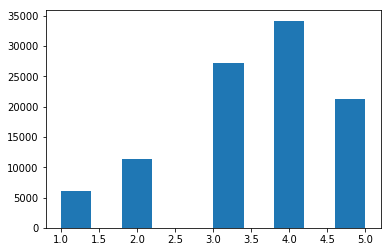

In [37]:
plt.hist(df['Rating'])

In [38]:
df.groupby(['Rating'])['UserID'].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

(array([  1.14600000e+03,   2.49000000e+02,   1.39000000e+02,
          6.70000000e+01,   3.80000000e+01,   2.40000000e+01,
          7.00000000e+00,   5.00000000e+00,   6.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   59.2,  117.4,  175.6,  233.8,  292. ,  350.2,  408.4,
         466.6,  524.8,  583. ]),
 <a list of 10 Patch objects>)

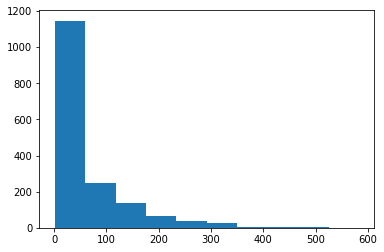

In [39]:
plt.hist(df.groupby(['ItemID'])['ItemID'].count())